This code is my assignment 8 for my machine learning module at UCL 2017/18. For this assignment I received 100% mark.

# Unsupervised learning: Mixture of Gaussians

In this assignment, your task will be to first generate some data from a mixture of Gaussians model and subsequently to fit a mixtures of Gaussians model to this data, and recover the original parameters.
    

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from construct_data_mod import construct_data, drawGaussianOutline, getGaussian2SD
from scipy.stats import multivariate_normal
from IPython import display

import time
import sys
flt_min = sys.float_info.min


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Set random seed for assignment
np.random.seed(1)

### Define parameters for a mixture of k Gaussians (MoG)

Here we are going to define the true parameters for a mixture of 3 Gaussians.
We are representing the mixture of Gaussians as a numpy dictionary. 
In d dimenisions, the mean field will be a $d\times k$ matrix and the cov field will be a $d\times d \times k$ matrix. The weight field corresponds to the weight of the mixture component i, $\pi_i$

In [2]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[ 4.0491 , 4.8597],[ 7.7578 , 1.6335],[ 11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'],mixGaussTrue['d'],mixGaussTrue['k']))
mixGaussTrue['cov'][:,:,0] = np.array([[  4.2534, 0.4791], [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[  0.9729, 0.8723],[  0.8723,  2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[  0.9886, -1.2244],[ -1.2244, 3.0187]])



<a id='question 1'></a>
# Generate data from MoG

Function `mixGaussGen` generates data by randomly sampling a mixture of gaussians. In order to sample the data:
1. We need to pick one of k components by sampling the discrete distribution formed by the MoG's weights.
2. Using the mean and covariance corresponding to the k-th component we sample a new daatapoint from a multivariate Gaussian distribution.

<b>Question 1:</b> Fill in the missing function from function `mixGaussGen`. The `sample_discrete` which randomly selects a component is given to you. Hint: use function `np.random.multivariate_normal` to randomly sample a multivariate Gaussian distribution.

In [3]:
# define number of samples to generate
nData = 400;

In [4]:
# draws a random sample from a discrete probability distribution 
def sample_discrete(discrete_distribution):
    bins = np.cumsum(discrete_distribution)
    rand_value = np.random.rand()
    for i in range(len(bins)):
        if rand_value<=bins[i]:
            return i   

In [5]:
# this function generates data from a k-dimensional                                           
# mixture of Gaussians structure.                                          
def mixGaussGen(mixGauss, nData):                                                                              
    # create space for output data                                                                               
        
    data = np.zeros(shape=(mixGauss['d'], nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = sample_discrete(mixGauss['weight'])                                                               
        # draw a sample from the appropriate Gaussian distribution  
        # using function np.random.multivariate_normal with the correct mean and covariance
        curMean = mixGauss['mean'][:,h]                                                                          
        curCov = mixGauss['cov'][:, :, h]  
        data[:, cData] = np.random.multivariate_normal(curMean, curCov)   
    
    
    return data         

In [6]:
# this routine draws the generated data and plots the MoG model on top of it
def drawEMData2d(data,mixGauss, title_text=""):    
    x_min = np.min(data[0,:])
    x_max = np.max(data[0,:])
    y_min = np.min(data[1,:])
    y_max = np.max(data[1,:])
    axes = plt.gca()
    axes.set_xlim([x_min-0.5,x_max+0.5])
    axes.set_ylim([y_min-0.5,y_max+0.5])
    plt.cla() 
    plt.plot(data[0,:],data[1,:],'k.')
    plt.title(title_text)
    for cGauss in range(mixGauss['k']):
        drawGaussianOutline(mixGauss['mean'][:,cGauss],mixGauss['cov'][:,:,cGauss],mixGauss['weight'][cGauss])    
    return  

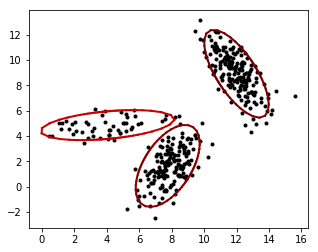

In [7]:
#generate data from the mixture of Gaussians
data = mixGaussGen(mixGaussTrue,nData)

#draw data, true Gaussians
drawEMData2d(data,mixGaussTrue)

<a id='question 2'></a>

# Calculate probability density of Mixture of gaussians

<b>Question 2:</b> Fill in the missing code for function `mixGaussPDF`. This function should give the result of the function: $$p(\vec{x})=\sum_{k=1}^{K}\pi_k* N(\vec{x}\vert\mu_k,\Sigma_k)$$

It should be able to handle multiple datapoints at once. The input should have dimensions $2\times N$ and the output $1\times N$. Hint: use the function `multivariate_normal.pdf` from scipy.stats to get the probability density of a multivariate normal distribution.

In [23]:
def mixGaussPDF(data, mixGaussEst):                                                             
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape 
    if nDims!=2:
        print('Error! Wrong number of dimensions for data!')
    
    probDensity = 0
    
    for curC in range(mixGaussEst['k']):                                                               
        curWeight = mixGaussEst['weight'][curC]                                                           
        curMean = mixGaussEst['mean'][:,curC]    
        curCov = mixGaussEst['cov'][:, :, curC]        
        probDensity = probDensity + curWeight*multivariate_normal.pdf(data.T, curMean,curCov) 
    return probDensity

<a id='question 3'></a>
# Calculate log likelihood of mixture of gaussians

<b>Question 3:</b> Fill in the missing code for function `getMixGaussLogLikelihood`. This function should return the log-likelihood for a set of points:
$$l(\theta;x) = \sum_{i=1}^N log(\sum_{k=1}^K \pi_k∗\mathcal{N}(\vec{x}^i|\mu_k,\Sigma_k))$$
 
The input should have dimensions  2×N  and the output is a single number. Hint: use the function multivariate_normal.pdf from scipy.stats to get the probability density of a multivariate normal distribution.

In [9]:
def getMixGaussLogLikelihood(data, mixGaussEst):                                                             
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape 
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        
        like = 0;
        for curC in range(mixGaussEst['k']):                                                               
            curWeight = mixGaussEst['weight'][curC]                                                           
            curMean = mixGaussEst['mean'][:,curC]    
            curCov = mixGaussEst['cov'][:, :, curC] 
            like = like + curWeight*multivariate_normal.pdf(data.T, curMean,curCov)
        
        # add to total log like                                                                        
        logLike = logLike + np.log(np.sum(like))                                                             
        
    return  np.asscalar(logLike)  

<a id='question 4'></a>
<a id='question 7'></a>
# Fit Mixture of Gaussians model to data 

This is the main part of our EM algorithm. Within this algorithm we iterate between the following two steps: 
* <b>Expectation Step:</b> in this step, we calculate a complete posterior distribution over each of the hidden variables (for each datapoint, we have a hidden variable assigning it to one of the mixtures)
* <b>Maximization Step:</b> in this step we update the parameters of the Gaussians (mean, cov, w) using the posterior distributions calculated during the expectation step. 

The pdf `MoGCribSheet.pdf` is given to you to help you with this part of the assignment.  
<b>Question 4:</b> Fill in the missing code in the EM algorithm. Follow the instructions given in the comments as well as the forementioned pdf.

In [10]:
def fitMixGauss(data, k, nIter = 20):
    nDims, nData = data.shape

    #     MAIN E-M ROUTINE
    #     there are nData data points, and there is a hidden variable associated
    #     with each.  If the hidden variable is 0 this indicates that the data was
    #     generated by the first Gaussian.  If the hidden variable is 1 then this
    #     indicates that the hidden variable was generated by the second Gaussian
    #     etc.

    postHidden = np.zeros(shape=(k, nData))

    #     in the E-M algorithm, we calculate a complete posterior distribution over each of
    #     the (nData) hidden variables in the E-Step.  In the M-Step, we
    #     update the parameters of the Gaussians (mean, cov, w).
    
    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))    
    
    # initialize means and covariances using data statistics
    mean_data = np.mean(data,axis=1)
    mixGaussEst['mean'] = (1 + 0.1*np.random.normal(size=(2,3)))*np.expand_dims(mean_data,axis=-1)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        cov_data = np.cov(data)
        mixGaussEst['cov'][:, :, cGauss] = cov_data*(1 +  0.1*np.random.normal())

    logLikelihoods_list = []
    logLikehood = getMixGaussLogLikelihood(data, mixGaussEst)
    #print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))
    logLikelihoods_list.append(logLikehood)

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        for cData in range(nData):

            thisData = data[:, cData]
            for curC in range(k):
                curWeight = mixGaussEst['weight'][curC]                                                           
                curMean = mixGaussEst['mean'][:,curC]    
                curCov = mixGaussEst['cov'][:, :, curC]     
                postHidden[curC, cData] = curWeight*multivariate_normal.pdf(thisData, curMean, curCov) 

            ## normalize the posterior probabilities
            postHidden[:, cData] = postHidden[:, cData] / (np.sum(postHidden[:, cData]) + flt_min)
            
        
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss
                        
            thisResp = postHidden[cGauss, :]

            mixGaussEst['weight'][cGauss] = np.mean(thisResp)
            
            # Update mean parameters mixGauss
            
            mixGaussEst['mean'][:, cGauss] = thisResp@data.T/np.sum(thisResp)
            
            # Update covariance parameter mixGauss
            a = data - mixGaussEst['mean'][:, cGauss][:,None]

            mixGaussEst['cov'][:, :, cGauss] = a@np.diag(thisResp)@a.T/ np.sum(thisResp)
            
            
            
        # draw the new solution
        title_text = "EM: Iteration %d"%(cIter)
        drawEMData2d(data, mixGaussEst, title_text )
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.3)

        # calculate the log likelihood
        logLikehood = getMixGaussLogLikelihood(data, mixGaussEst)
        logLikelihoods_list.append(logLikehood)
        #print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))
    
    # Plot the likelihoods after each iteration
    fig = plt.figure()
    plt.plot(logLikelihoods_list)
    plt.xlabel('Iteration')
    plt.title('Log-Likelihood')

    return mixGaussEst

Now we use the completed function `fitMixGauss` to fit our data.

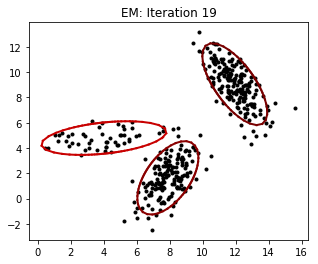

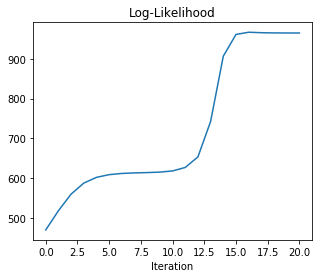

In [11]:
#define number of components to estimate
nGaussEst = 3

#fit mixture of Gaussians 
mixGaussEst = fitMixGauss(data,nGaussEst,nIter=20);



<a id='question 5'></a>
## Use mixture of Gaussians for classification

We will now use the dataset we used in previous assignments for classification. This dataset is actually generated using 2 mixtures of Gaussians with 3 and 4 components for the positive and negative classes respectively. 

<b>Question 5:</b> Use function `fitMixGauss` to get an estimate on the parameters of these two mixtures of gaussians. 

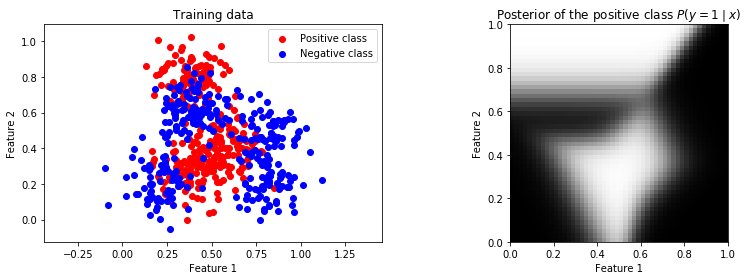

In [12]:
training_features, training_labels, posterior = construct_data(600, 'train', 'nonlinear' , plusminus=False)

# Extract features for both classes
features_pos = training_features[training_labels == 1].T
features_neg = training_features[training_labels != 1].T

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[0,:], features_pos[1,:], c="red", label="Positive class")
ax.scatter(features_neg[0,:], features_neg[1,:], c="blue", label="Negative class")
ax.axis('equal')
ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()



<a id='question 5a'></a>
## Fit mixture of Gaussians with 2 components to the positive class.

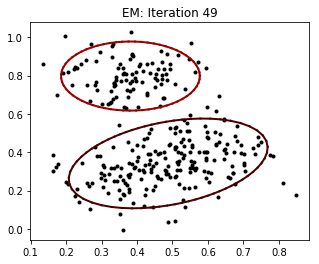

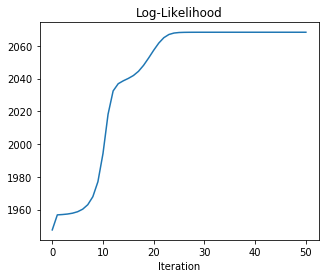

In [27]:
#define number of components to estimate
numGaussPositive_Est = 2

# fill in the correct arguments
mixGaussPositive_Est = fitMixGauss(features_pos,numGaussPositive_Est, nIter = 50)


<a id='question 5b'></a>
## Fit mixture of Gaussians with 2 components to the negative class.

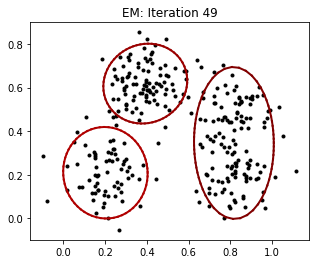

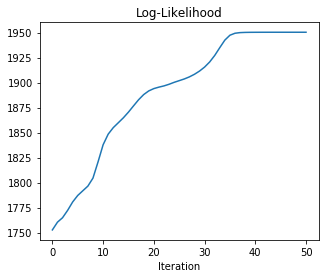

In [28]:
#define number of components to estimate
numGaussNegative_Est = 3

# fill in the correct arguments
mixGaussNegative_Est = fitMixGauss(features_neg,numGaussNegative_Est, nIter = 50)


<a id='question 6'></a>
## Calculate the posterior for the positive class.
For this part of the assignment you need to use the two class conditional distributions for the positive and the negative class ( the mixture of gaussians you've just estimated), the priors for each class and Bayes' rule to calculate the posterior distribution for the positive class. You're also going to use function `mixGaussPDF` here.

<b>Question 6:</b> Calculate the posterior for the positive class using Bayes' rule and compare it to the actual posterior.

In [29]:
x_range = np.linspace(0, 1, 50)
y_range = np.linspace(0, 1, 50)
grid_x, grid_y = np.meshgrid(x_range, y_range)
xy_array = np.row_stack([grid_x.flat, grid_y.flat])

# calculate class conditional probabilities for positive and negative class

pos_class_on_grid = mixGaussPDF(xy_array,mixGaussPositive_Est)
neg_class_on_grid = mixGaussPDF(xy_array,mixGaussNegative_Est)

# calculate prior probabilities for positive and negative class
prior_pos = len(features_pos[0])/len(features_pos[0]) + len(features_neg[0])
prior_neg = len(features_neg[0])/len(features_pos[0]) + len(features_neg[0])

# calculate posterior probabilities for positive class using Bayes' rule
posterior_positive = pos_class_on_grid * prior_pos/(neg_class_on_grid * prior_neg +pos_class_on_grid * prior_pos ) 

# reshape posterior probability to plot it as an image
posterior_positive = posterior_positive.reshape(grid_x.shape)



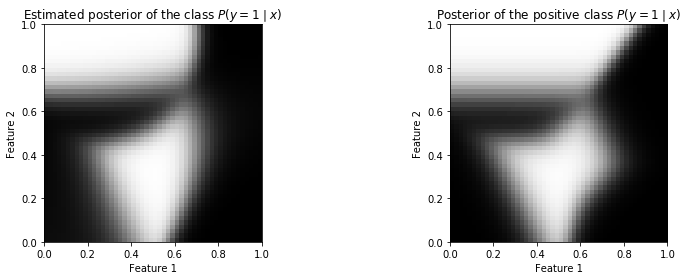

In [30]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(posterior_positive, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Estimated posterior of the class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()